/webapps/firecares/local/lib/python2.7/site-packages/tastypie/fields.py:7: RemovedInDjango19Warning: django.utils.importlib will be removed in Django 1.9.
  from django.utils import importlib

  from django.utils import importlib

/webapps/firecares/local/lib/python2.7/site-packages/tastypie/cache.py:62: RemovedInDjango19Warning: 'get_cache' is deprecated in favor of 'caches'.
  self.cache = get_cache(cache_name)

  self.cache = get_cache(cache_name)



Number of unmatched fire stations: 50743
Axes(0.125,0.125;0.775x0.775)


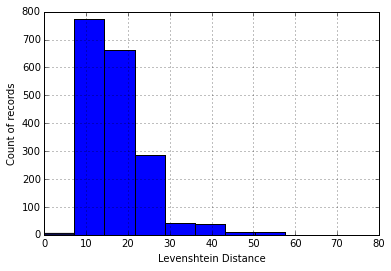

In [2]:
import sys
sys.path.append("../../")

import django
import pylab as pl

from django.db import connections
from firecares.firestation.models import FireDepartment, FireStation
from firecares.utils import dictfetchall
from pandas import DataFrame


%matplotlib inline

django.setup()

print "Number of unmatched fire stations:", FireStation.objects.filter(department__isnull=True).count()

cursor = connections['default'].cursor()
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, a.name) 
from firestation_usgsstructuredata a 
inner join firestation_firestation b
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)

# distribution of levenshtein distances
pl.xlabel("Levenshtein Distance")
pl.ylabel("Count of records")
print df['levenshtein'].hist()




Axes(0.125,0.125;0.775x0.775)


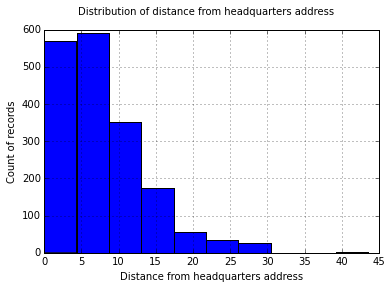

In [4]:
query = """
select c.name as department_name, a.name as department_name, levenshtein(c.name, a.name), ST_DISTANCE(ST_Transform(e.geom, 900913), ST_Transform(d.geom, 900913)) as dis 
from firestation_usgsstructuredata a 
inner join firestation_firestation b 
  on a.id=b.usgsstructuredata_ptr_id 
join firestation_firedepartment c 
  on b.department_id=c.id 
join firecares_core_address d 
  on b.station_address_id=d.id
join firecares_core_address e 
  on c.headquarters_address_id=e.id
where e.geom is not null and c.geom is not null;  
  ;
"""
cursor.execute(query)
results = dictfetchall(cursor)
df = DataFrame(results)

# distribution of levenshtein distances
pl.suptitle("Distribution of distance from headquarters address")
pl.xlabel("Distance from headquarters address")
pl.ylabel("Count of records")

# convert meters to miles.
df['dis_mi'] = df['dis'] * 0.000621371
print df['dis_mi'].hist()
